In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Dummy dataset for demonstration
class NoisyDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=20, noise_factor=0.5):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.noise_factor = noise_factor
        self.data = np.sin(np.linspace(0, 50, seq_length)) + np.random.normal(0, 0.1, seq_length)
        self.data = np.tile(self.data, (num_samples, 1))
        self.noisy_data = self.data + noise_factor * np.random.normal(size=self.data.shape)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.noisy_data[idx], dtype=torch.float32), torch.tensor(self.data[idx], dtype=torch.float32)

# Transformer Autoencoder Model
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3):
        super(TransformerAutoencoder, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training function
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for noisy_data, clean_data in dataloader:
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = criterion(output, clean_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}")

# Prepare dataset and dataloader
dataset = NoisyDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model and train
model = TransformerAutoencoder(input_dim=20)
train_model(model, dataloader)


F:\projects\ResearchProject\venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/10], Loss: 0.071705
Epoch [2/10], Loss: 0.016974
Epoch [3/10], Loss: 0.011243
Epoch [4/10], Loss: 0.006727
Epoch [5/10], Loss: 0.003477
Epoch [6/10], Loss: 0.002139
Epoch [7/10], Loss: 0.001584
Epoch [8/10], Loss: 0.001243
Epoch [9/10], Loss: 0.001077
Epoch [10/10], Loss: 0.000946


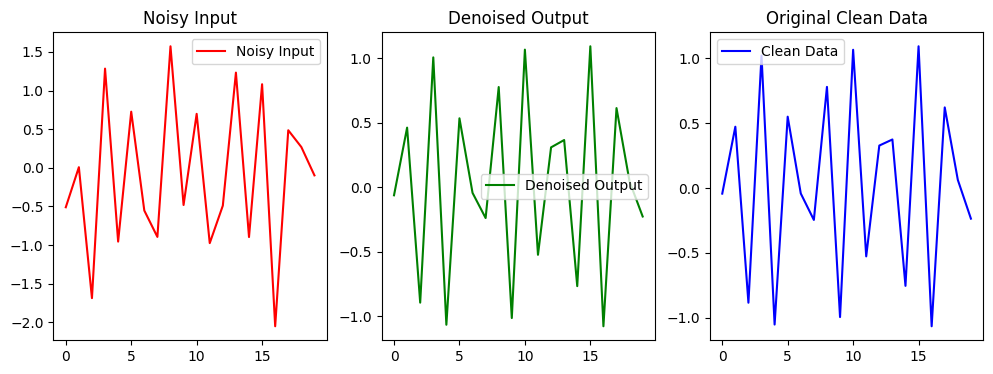

In [2]:
import matplotlib.pyplot as plt
import torch

# Get a batch of test data
noisy_sample, clean_sample = next(iter(dataloader))
noisy_sample, clean_sample = noisy_sample[0].numpy(), clean_sample[0].numpy()

noisy_sample_tensor = torch.tensor(noisy_sample, dtype=torch.float32).unsqueeze(0)  # Add batch dim

# Get model output (denoised sample)
model.eval()
with torch.no_grad():
    denoised_sample = model(noisy_sample_tensor).squeeze(0).numpy()  # Remove batch dim for plotting

# Plot before and after
plt.figure(figsize=(12, 4))

# Noisy input
plt.subplot(1, 3, 1)
plt.plot(noisy_sample, label="Noisy Input", color='r')
plt.title("Noisy Input")
plt.legend()

# Denoised output
plt.subplot(1, 3, 2)
plt.plot(denoised_sample, label="Denoised Output", color='g')
plt.title("Denoised Output")
plt.legend()

# Original clean data
plt.subplot(1, 3, 3)
plt.plot(clean_sample, label="Clean Data", color='b')
plt.title("Original Clean Data")
plt.legend()

plt.show()
